In [33]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from config import *

In [34]:
# path = r'./input/78_columns_mfcc.xlsx'
path = r'./input/78_columns_mfcc_use_laeq.xlsx'
data = pd.read_excel(path)
X = data[used_feature_columns].values
y = data['score'].values

In [35]:
# 将数据集划分为训练集、验证集和测试集
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

# 2. 定义模型并进行交叉验证
params = {
    "objective": "reg:squarederror",
    "eta": 0.1,
    "max_depth": 8,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.3,
    "seed": 42,
    # "seed": 3,
}
num_rounds = 200

In [36]:
# 使用交叉验证进行模型选择
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5折交叉验证
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"Training fold {fold}...")
    X_fold_train, y_fold_train = X_train_val[train_idx], y_train_val[train_idx]
    X_fold_val, y_fold_val = X_train_val[val_idx], y_train_val[val_idx]

    dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
    dval = xgb.DMatrix(X_fold_val, label=y_fold_val)

    bst = xgb.train(params, dtrain, num_rounds, evals=[(dval, "val")], verbose_eval=10)
    # print(f"Fold {fold} best score: {bst.best_score}\n")

# 3. 在全量数据上重新训练模型，并在测试集上评估模型表现
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=used_feature_columns)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=used_feature_columns)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=used_feature_columns)
# dall = xgb.DMatrix(X, label=y, feature_names=used_feature_columns)
# dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val, feature_names=used_feature_columns)

watchlist = [(dtrain, "train"), (dval, "val")]
# bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=10, verbose_eval=10)
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=10, verbose_eval=10)
# bst = xgb.train(params, dtrain_val, num_rounds, evals=watchlist, early_stopping_rounds=10, verbose_eval=10)

# 在测试集上评估模型表现
y_pred = bst.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
print(f"Test set MSE: {mse:.4f}")

Training fold 0...
[0]	val-rmse:4.38382
[10]	val-rmse:1.68537
[20]	val-rmse:0.89019
[30]	val-rmse:0.71776
[40]	val-rmse:0.69541
[50]	val-rmse:0.69168
[60]	val-rmse:0.69096
[70]	val-rmse:0.68900
[80]	val-rmse:0.68907
[90]	val-rmse:0.68864
[100]	val-rmse:0.68860
[110]	val-rmse:0.68812
[120]	val-rmse:0.68793
[130]	val-rmse:0.68819
[140]	val-rmse:0.68830
[150]	val-rmse:0.68830
[160]	val-rmse:0.68830
[170]	val-rmse:0.68833
[180]	val-rmse:0.68819
[190]	val-rmse:0.68825
[199]	val-rmse:0.68835
Training fold 1...
[0]	val-rmse:4.42670
[10]	val-rmse:1.76155
[20]	val-rmse:0.96899
[30]	val-rmse:0.77075
[40]	val-rmse:0.72371
[50]	val-rmse:0.71006
[60]	val-rmse:0.70670
[70]	val-rmse:0.70597
[80]	val-rmse:0.70639
[90]	val-rmse:0.70589
[100]	val-rmse:0.70525
[110]	val-rmse:0.70494
[120]	val-rmse:0.70466
[130]	val-rmse:0.70471
[140]	val-rmse:0.70451
[150]	val-rmse:0.70437
[160]	val-rmse:0.70432
[170]	val-rmse:0.70429
[180]	val-rmse:0.70436
[190]	val-rmse:0.70435
[199]	val-rmse:0.70440
Training fold 2...

In [37]:
# 保存模型
bst.save_model("xgboost_model_use_laeq.model")

In [38]:
a = pd.DataFrame()
a['true'] = y_test
a['predict'] = y_pred
a['difference'] = abs(y_pred - y_test)
a

,true,predict,difference
0,3.325,4.750897,1.425897
1,3.700,4.824118,1.124118
2,6.200,6.386240,0.186240
3,4.050,4.514680,0.464680
4,4.100,4.265835,0.165835
...,...,...,...
130,5.700,5.855963,0.155963
131,5.600,6.087843,0.487843
132,4.200,4.561757,0.361757
133,6.800,5.601165,1.198835


In [39]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from model.cal_accuracy import *

r2 = r2_score(a['true'], a['predict'])
mae = mean_absolute_error(a['true'], a['predict'])
rmse = mean_squared_error(a['true'], a['predict'], squared=False)

predict_class_list = []
true_class_list = []
for i in range(len(a)):
    predict_class, true_class = classify(a.predict[i], a.true[i])
    predict_class_list.append(predict_class)
    true_class_list.append(true_class)

acc_4_class = accuracy(predict_class_list, true_class_list)

threshold = 1
count = (a['difference'] < threshold).sum()
acc = count / len(a)
acc

# print('r2:', r2)
print("MAE: {:.2f} ".format(mae))
print("RMSE: {:.2f}".format(rmse))
print("4-Class Accuracy: {:.2f}".format(acc_4_class))
print("abs-1 Accuracy: {:.2f}".format(acc))

MAE: 0.57 
RMSE: 0.73
4-Class Accuracy: 0.86
abs-1 Accuracy: 0.84


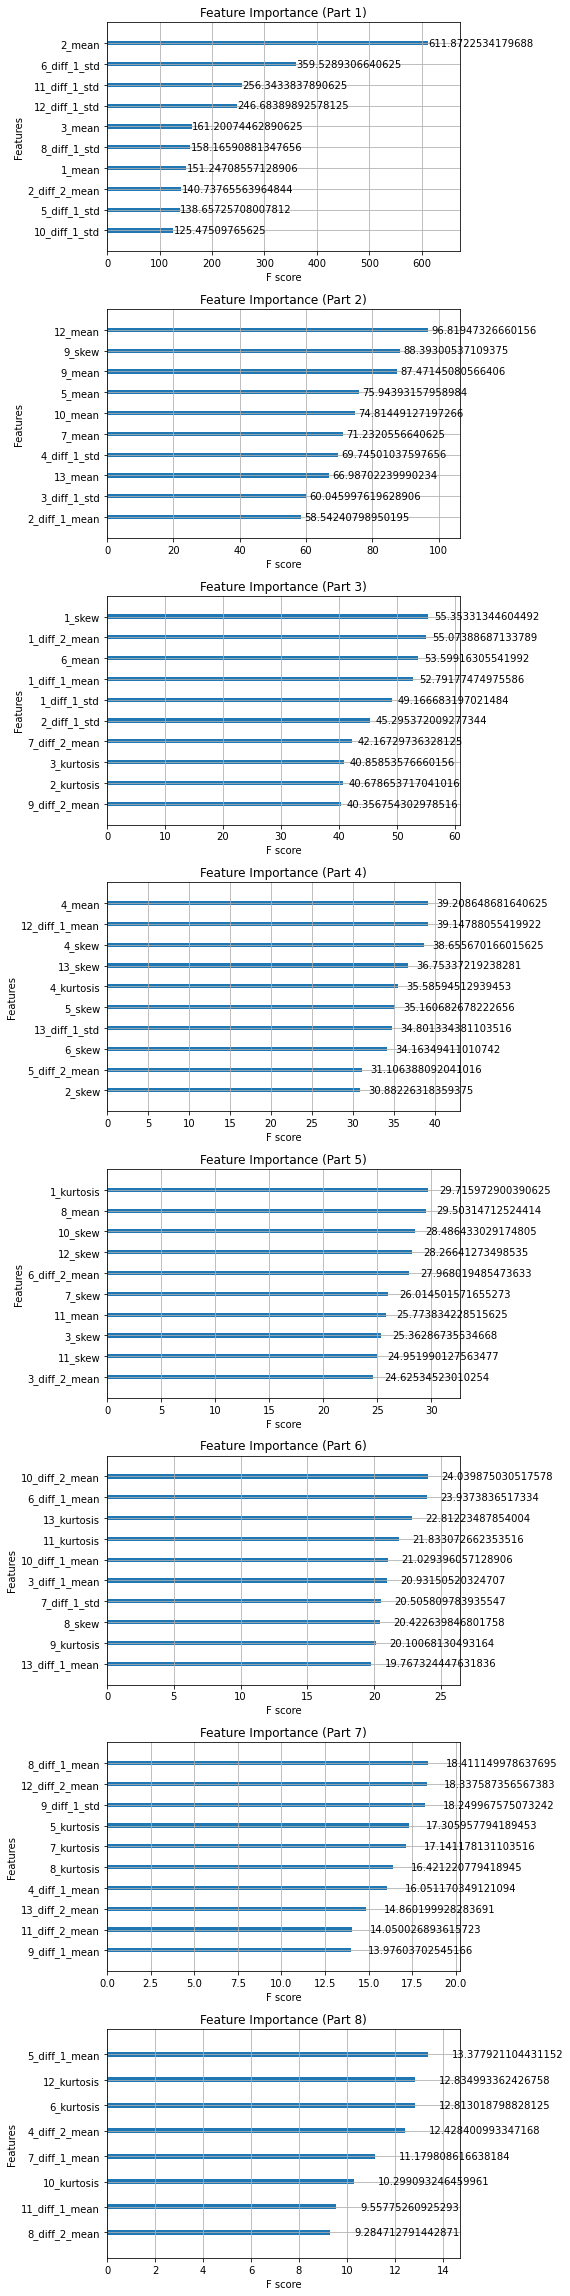

In [40]:
import matplotlib.pyplot as plt

# 获取特征重要性
# importance = bst.get_score(importance_type='weight')
# importance = bst.get_score(importance_type='gain')
# importance = bst.get_score(importance_type='cover')
importance = bst.get_score(importance_type='total_gain')
sorted_imp = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# 每张图显示的特征数量
num_features_per_plot = 10

# 计算需要几张图
num_plots = len(sorted_imp) // num_features_per_plot + 1

# 创建多个子图
fig, axes = plt.subplots(num_plots, figsize=(8, num_plots * 4))

# 绘制每个子图中的特征重要性
for i, ax in enumerate(axes.flat):
    start_idx = i * num_features_per_plot
    end_idx = (i + 1) * num_features_per_plot
    imp_subset = dict(sorted_imp[start_idx:end_idx])
    xgb.plot_importance(imp_subset, ax=ax)
    ax.set_title(f'Feature Importance (Part {i + 1})')

plt.tight_layout()
plt.show()